In [16]:
! pip install pyreadstat pyarrow matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [17]:
import pandas as pd

Taiwan_QQQ = pd.read_feather("Cleaned_2018_Reading.feather")

# 切割資料集為訓練集和測試集
from sklearn.model_selection import train_test_split

X = Taiwan_QQQ.drop(['Reading_level'], axis=1)
y = Taiwan_QQQ['Reading_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(X_train, y_train)
mi_scores = pd.Series(mi, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)  # 降序排序
print(mi_scores[:100])

JOYREAD       0.112564
METASPAM      0.096744
ST165Q04IA    0.093435
RESPECT       0.076093
METASUM       0.075691
                ...   
IC152Q02HA    0.028325
MISCED        0.028282
ST023Q05TA    0.028121
ST167Q04IA    0.028027
ST177Q01HA    0.027682
Length: 100, dtype: float64


In [19]:
selected_column = mi_scores[:100].keys()
X_train = X_train[selected_column]
X_test = X_test[selected_column]

X_train.head()

,JOYREAD,METASPAM,ST165Q04IA,RESPECT,METASUM,ST225Q06HA,INFOCAR,ST168Q01HA,SCREADCOMP,HOMESCH,...,ST215Q01HA,ADAPTIVITY,ST188Q02HA,ICTOUTSIDE,ICTHOME,IC152Q02HA,MISCED,ST023Q05TA,ST167Q04IA,ST177Q01HA
571621,-0.6996,-1.41,3.0,-0.4401,-0.18,0.0,2.2523,3.0,-1.0985,-2.2971,...,2.0,0.1915,3.0,-1.3048,6.0,1.0,5.0,3.0,4.0,1.0
568626,0.6380,0.42,4.0,-0.4401,1.36,1.0,-0.6558,2.0,0.1222,0.0303,...,2.0,-0.2644,3.0,-0.0267,6.0,4.0,6.0,4.0,4.0,4.0
572855,-2.7114,0.42,4.0,0.9289,0.21,1.0,-1.0276,1.0,-2.4403,-2.2971,...,3.0,0.1915,3.0,-1.3048,6.0,4.0,5.0,3.0,5.0,2.0
573892,-0.9615,-1.41,1.0,-2.1937,-1.72,0.0,-1.0276,1.0,-1.4704,-0.9320,...,5.0,0.0210,2.0,-1.3048,3.0,1.0,5.0,1.0,1.0,1.0
573109,1.4712,-0.04,4.0,-1.4721,-0.57,1.0,-1.9096,4.0,0.1222,0.4754,...,1.0,-2.2652,3.0,-1.3048,6.0,4.0,5.0,3.0,3.0,1.0


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])

# 設定參數網格
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': [0.1, 1, 10]
}

# 創建 GridSearchCV 物件
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, verbose=4, n_jobs=-1)

# 執行網格搜索
svm_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = svm_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j + 1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", svm_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(svm_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
best_model = svm_grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}
Fold 1 score: 0.819672131147541
Fold 2 score: 0.8032786885245902
Fold 3 score: 0.8075927523727351
Fold 4 score: 0.825711820534944
Fold 5 score: 0.8255613126079447
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Fold 1 score: 0.5202761000862812
Fold 2 score: 0.5220017256255393
Fold 3 score: 0.5237273511647972
Fold 4 score: 0.5220017256255393
Fold 5 score: 0.5198618307426598
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Fold 1 score: 0.818809318377912
Fold 2 score: 0.7782571182053495
Fold 3 score: 0.7748058671268335
Fold 4 score: 0.7860224331320104
Fold 5 score: 0.7815198618307426
Params: {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'linear'}
Fold 1 score: 0.819672131147541
Fold 2 score: 0.8032786885245902
Fold 3 score: 0.8075927523727351
Fold 4 score: 0.825711820534944
Fold 5 score: 0.8255613126079447
Params: {'svm__C':

In [21]:
from sklearn.ensemble import RandomForestClassifier

# 設定參數網格
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # 決策樹的數量
    'max_depth': [None, 10, 20, 30],  # 最大深度
    'min_samples_split': [2, 5, 10],  # 每個節點至少包含的數據量，才能繼續分割
    'min_samples_leaf': [1, 2, 4]  # 每個葉子最少的樣本數
}

# 創建 GridSearchCV 物件
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, verbose=2, n_jobs=-1)

# 執行網格搜索
rf_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = rf_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j + 1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", rf_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(rf_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
rf_best_model = rf_grid_search.best_estimator_
rf_test_score = rf_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(rf_test_score))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold 1 score: 0.817083692838654
Fold 2 score: 0.8015530629853321
Fold 3 score: 0.808455565142364
Fold 4 score: 0.7989646246764452
Fold 5 score: 0.7953367875647669
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fold 1 score: 0.8308886971527178
Fold 2 score: 0.8024158757549612
Fold 3 score: 0.817083692838654
Fold 4 score: 0.808455565142364
Fold 5 score: 0.802245250431779
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fold 1 score: 0.8265746333045729
Fold 2 score: 0.7963761863675582
Fold 3 score: 0.8127696289905091
Fold 4 score: 0.8041415012942191
Fold 5 score: 0.803972366148532
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Fold 1 score: 0.823123382226057
Fold 2 score: 0.8058671268334772

In [22]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# 设置参数网格
xg_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 3]
}

# 创建 GridSearchCV 对象
xg_grid_search = GridSearchCV(xgb_model, xg_param_grid, cv=5, verbose=4, n_jobs=-1)

# 执行网格搜索
xg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = xg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j + 1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", xg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(xg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
xgb_best_model = xg_grid_search.best_estimator_
xgb_test_score = xgb_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(xgb_test_score))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}
Fold 1 score: 0.7601380500431406
Fold 2 score: 0.7566867989646247
Fold 3 score: 0.7756686798964625
Fold 4 score: 0.7661777394305436
Fold 5 score: 0.7797927461139896
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Fold 1 score: 0.7782571182053495
Fold 2 score: 0.7687661777394306
Fold 3 score: 0.7782571182053495
Fold 4 score: 0.7825711820534944
Fold 5 score: 0.7892918825561313
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
Fold 1 score: 0.7981018119068162
Fold 2 score: 0.7773943054357204
Fold 3 score: 0.7989646246764452
Fold 4 score: 0.8006902502157032
Fold 5 score: 0.8048359240069085
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50}
Fold 1 score: 0.7601380500431406
Fold 2 score: 0.7566867989646247
Fold 3 scor

In [23]:
from sklearn.linear_model import LogisticRegression

# 设置参数网格
lg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# 创建 GridSearchCV 对象
lg_grid_search = GridSearchCV(LogisticRegression(solver='saga'), lg_param_grid, cv=5, verbose=2, n_jobs=-1)

# 执行网格搜索
lg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = lg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j + 1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", lg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(lg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
lg_best_model = lg_grid_search.best_estimator_
lg_test_score = lg_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(lg_test_score))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

Params: {'C': 0.01, 'penalty': 'l1'}
Fold 1 score: 0.7480586712683348
Fold 2 score: 0.7006039689387403
Fold 3 score: 0.6660914581535806
Fold 4 score: 0.6721311475409836
Fold 5 score: 0.6796200345423143
Params: {'C': 0.01, 'penalty': 'l2'}
Fold 1 score: 0.7480586712683348
Fold 2 score: 0.7152717860224331
Fold 3 score: 0.6824849007765315
Fold 4 score: 0.6798964624676446
Fold 5 score: 0.6839378238341969
Params: {'C': 0.1, 'penalty': 'l1'}
Fold 1 score: 0.7480586712683348
Fold 2 score: 0.7152717860224331
Fold 3 score: 0.6781708369283865
Fold 4 score: 0.6773080241587576
Fold 5 score: 0.6822107081174439
Params: {'C': 0.1, 'penalty': 'l2'}
Fold 1 score: 0.7480586712683348
Fold 2 score: 0.7152717860224331
Fold 3 score: 0.6824849007765315
Fold 4 score: 0.6790336496980155
Fold 5 score: 0.6839378238341969
Params: {'C': 1, 'penalty': 'l1'}
Fold 1 score: 0.7480586712683348
Fold 2 score: 0.7152717860224331
Fold 3 score: 0.6824849007765315
Fold 4 score: 0.6798964624676446
Fold 5 score: 0.683937823834

/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [24]:
import shap
import xgboost as xgb
from sklearn.model_selection import KFold

# {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 200}
# classifier = xgb.XGBClassifier(n_estimators=200,min_child_weight=3,max_depth=5, learning_rate=0.1)
rf_best_model.score(X_test, y_test)

0.7943409247757074

In [25]:
explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(X_test)

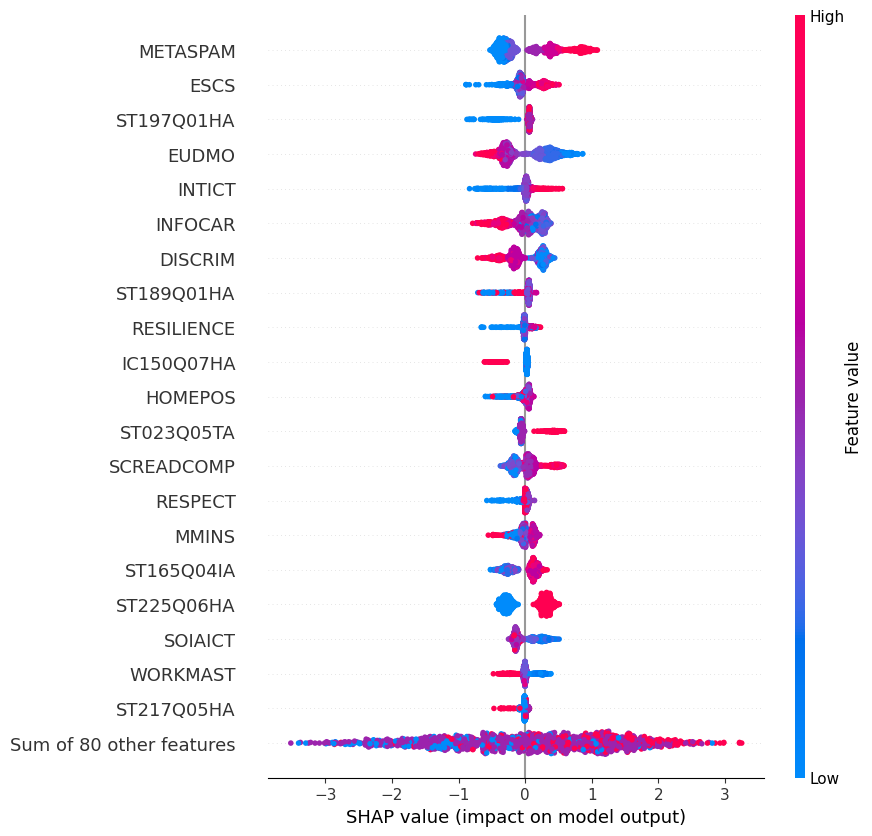

In [29]:
shap.plots.beeswarm(shap_values, max_display=21, order=shap_values.abs.max(0))

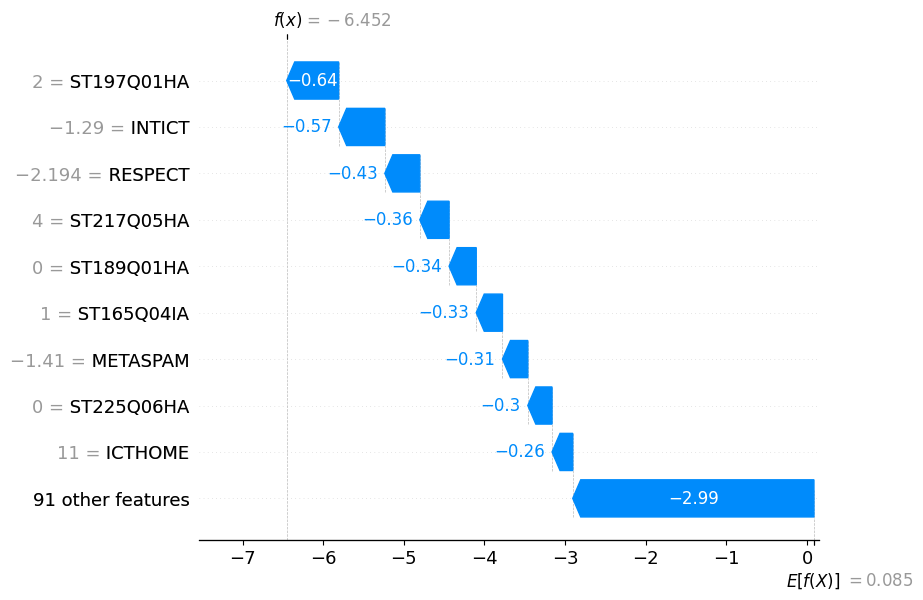

In [27]:
shap.plots.waterfall(shap_values[2])